In [11]:
from l3gs.data.utils.pyramid_embedding_dataloader2 import PyramidEmbeddingDataloader
from l3gs.data.utils.dino_dataloader2 import DinoDataloader
from l3gs.encoders.image_encoder import BaseImageEncoderConfig
from l3gs.encoders.openclip_encoder import OpenCLIPNetworkConfig
from datasets import load_dataset
from torch.utils import data
from typing import Dict, ForwardRef, Generic, List, Literal, Optional, Tuple, Type, Union, cast, get_args, get_origin
from torchvision import transforms
import matplotlib.pyplot as plt
from nerfstudio.utils.colormaps import apply_colormap
import torch

device = 'cuda:0'
"""The device to run on"""
patch_tile_size_range: Tuple[int, int] = (0.08, 0.5)
"""The range of tile sizes to sample from for patch-based training"""
patch_tile_size_res: int = 7
"""The number of tile sizes to sample from for patch-based training"""
patch_stride_scaler: float = 0.5
"""The stride scaler for patch-based training"""
network: BaseImageEncoderConfig = OpenCLIPNetworkConfig(device=device)
"""specifies the vision-language network config"""
clip_downscale_factor: int = 1
"""The downscale factor for the clip pyramid"""

dino_dataloader = DinoDataloader(
            # image_list=images,
            device=device,
            cfg={"image_shape": [480,640]},
            # cache_path=dino_cache_path,
        )
torch.cuda.empty_cache()

clip_interpolator = PyramidEmbeddingDataloader(
    device=device,
    cfg={
        "tile_size_range": list(patch_tile_size_range),
        "tile_size_res": patch_tile_size_res,
        "stride_scaler": patch_stride_scaler,
        "image_shape": [480,640],
    },
    model=network.setup()
)
image_encoder = clip_interpolator.model

transform = transforms.Compose([
    transforms.ToTensor()
])

In [12]:
import torchvision

def tt2clipinterp(tt_frame, clip_downscale_factor=1):
    to_pil = torchvision.transforms.ToPILImage()
    image = transform(to_pil(tt_frame.permute(2, 0, 1).to(torch.uint8)))
    clip_interpolator.generate_clip_interp(image)
    H, W = image.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    with torch.no_grad():
        # data["clip"], data["clip_scale"] = clip_interpolator(positions, scale)[0], clip_interpolator(positions, scale)[1]
        data = clip_interpolator(positions)[0].view(H, W, -1)
    return data

def tt2dino(tt_frame, clip_downscale_factor=1):
    im = tt_frame.permute(2, 0, 1).to(torch.float32)
    dino_dataloader.generate_dino_embed(im)
    H, W = im.shape[1:]
    # scale = torch.tensor(0.1).to(device)
    scaled_height = H//clip_downscale_factor
    scaled_width = W//clip_downscale_factor

    x = torch.arange(0, scaled_width*clip_downscale_factor, clip_downscale_factor).view(1, scaled_width, 1).expand(scaled_height, scaled_width, 1).to(device)
    y = torch.arange(0, scaled_height*clip_downscale_factor, clip_downscale_factor).view(scaled_height, 1, 1).expand(scaled_height, scaled_width, 1).to(device)
    image_idx_tensor = torch.zeros(scaled_height, scaled_width, 1).to(device)
    positions = torch.cat((image_idx_tensor, y, x), dim=-1).view(-1, 3).to(int)
    # print(positions.device)
    with torch.no_grad():
        data = dino_dataloader(positions.cpu()).view(H, W, -1)
    return data


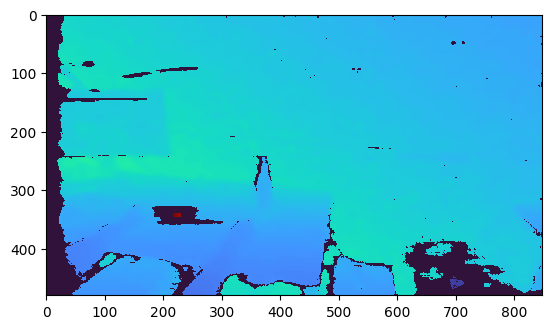

In [13]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


with open('/home/yujustin/HDD2/rs_diff_cap/cap1png/cap1_Depth_1717622487708.12353515625000.bin', 'rb') as f:
    img = np.frombuffer(f.read(), dtype=np.float32).reshape(480, 848, 1)
    plt.imshow(img[:,:,0], interpolation='nearest', cmap='turbo')
    plt.show()
    

# from IPython.display import Image
# Image(filename='/home/yujustin/HDD2/rs_diff_cap/cap1png/cap1png_Depth_1717622487708.12353515625000.png') 

/tmp/ipykernel_2923/2380112002.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


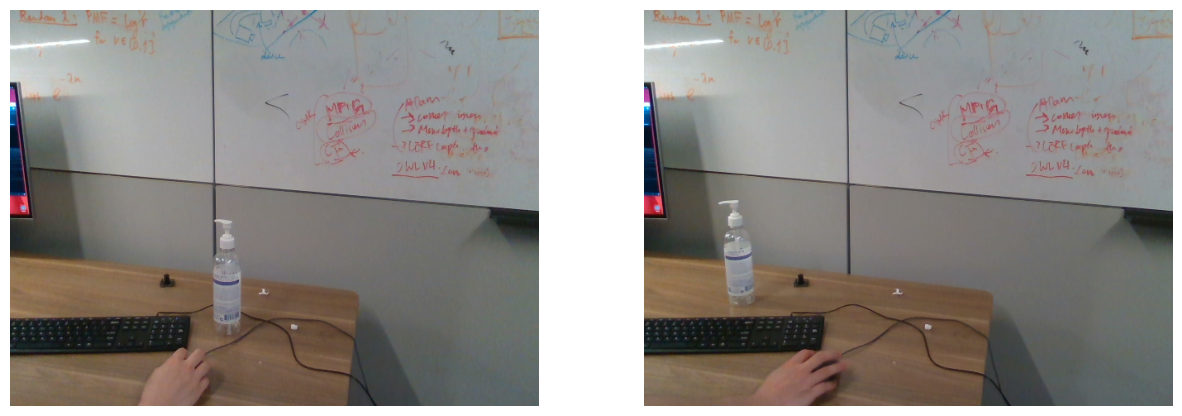

In [14]:
from PIL import Image
im_frame1 = Image.open('/home/yujustin/HDD2/rs_diff_cap/cap1png/cap1png_Color_1717622487708.14160156250000.png')
np_frame1 = np.array(im_frame1)
im_frame2 = Image.open('/home/yujustin/HDD2/rs_diff_cap/cap2png/_Color_1717622591549.77758789062500.png')
np_frame2 = np.array(im_frame2)

f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].imshow(np_frame1)
axarr[1].imshow(np_frame2)
axarr[0].axis('off')
axarr[1].axis('off')
f.show()

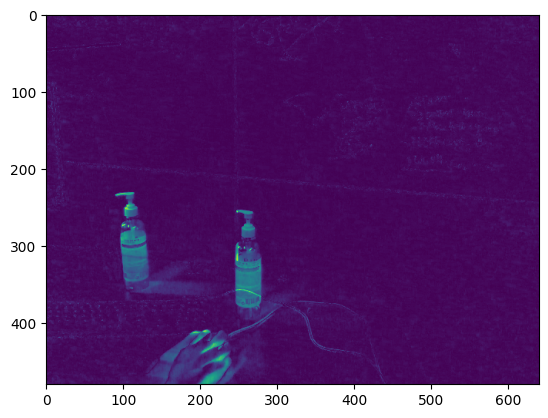

L2-Norm:  7.27804708480835


In [15]:
np_l2_dist = np.linalg.norm(np_frame1.astype(np.int8) - np_frame2.astype(np.int8), axis=2)
plt.imshow(np_l2_dist)
plt.show()
import torch
tt_frame1 = torch.from_numpy(np_frame1.astype(np.int8))
tt_frame2 = torch.from_numpy(np_frame2.astype(np.int8))

l2_norm = torch.norm((tt_frame1 - tt_frame2).to(torch.float32), p=2, dim=2).mean()
print("L2-Norm: ", l2_norm.item())

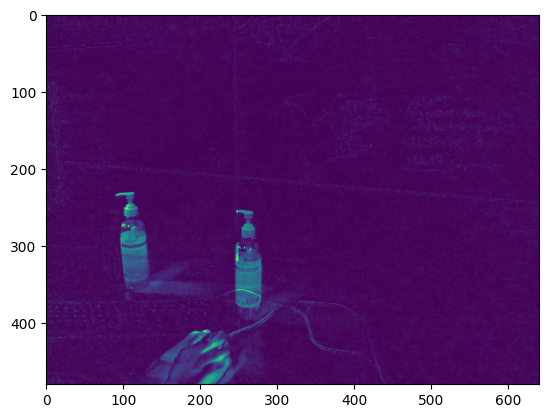

L1-Norm:  11.254778861999512


In [16]:
np_l1_dist = np.linalg.norm(np_frame1.astype(np.int8) - np_frame2.astype(np.int8), axis=2, ord=1)
plt.imshow(np_l1_dist)
plt.show()
import torch
tt_frame1 = torch.from_numpy(np_frame1.astype(np.int8))
tt_frame2 = torch.from_numpy(np_frame2.astype(np.int8))

l1_norm = torch.norm((tt_frame1 - tt_frame2).to(torch.float32), p=1, dim=2).mean()
print("L1-Norm: ", l1_norm.item())

Scales: 100%|██████████| 7/7 [00:00<00:00, 9186.52it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales:   0%|          | 0/7 [00:00<?, ?it/s]/home/yujustin/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Scales: 100%|██████████| 7/7 [00:00<00:00, 15.42it/s]


PyramidEmbeddingProcess took 0.4547281265258789 seconds


Scales: 100%|██████████| 7/7 [00:00<00:00, 9654.76it/s]


here 38 32 19
here 72 36 36
here 105 52 52
here 139 69 69
here 172 86 86
here 206 103 103
here 240 120 120


Scales: 100%|██████████| 7/7 [00:00<00:00, 15.66it/s]


PyramidEmbeddingProcess took 0.4477345943450928 seconds
(480, 640)


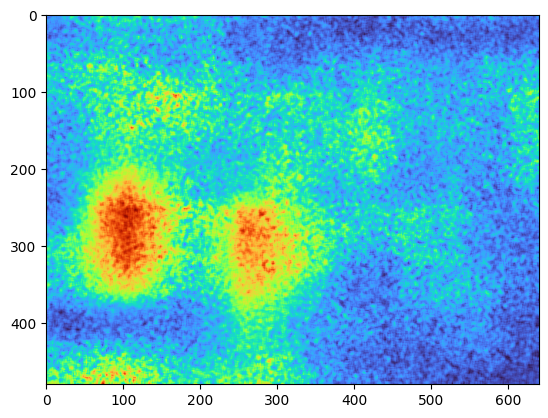

In [17]:
clip1 = tt2clipinterp(tt_frame1)
clip2 = tt2clipinterp(tt_frame2)
cos_sim = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(5.0))

np_cos_sim = cos_sim(clip1, clip2).cpu().numpy()

np_cos_sim = gaussian_blur(cos_sim(clip1, clip2).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).cpu().numpy()
print(np_cos_sim.shape)

np_dist = (clip1.to(torch.float32) - clip2.to(torch.float32)).mean(dim=2).cpu().numpy()
#normalize to 0-1
np_dist = (np_dist - np_dist.min()) / (np_dist.max() - np_dist.min())

plt.imshow(np_cos_sim, cmap='turbo_r')

# print((np_cos_sim == np_cos_sim.min()).nonzero())
# ch, cw = (np_cos_sim == np_cos_sim.min()).nonzero()
# circle1 = plt.Circle((cw, ch), 2, color='r')
# plt.gca().add_patch(circle1)
# plt.show()

Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yujustin/.cache/torch/hub/facebookresearch_dino_main


torch.Size([480, 640, 384])
(480, 640)


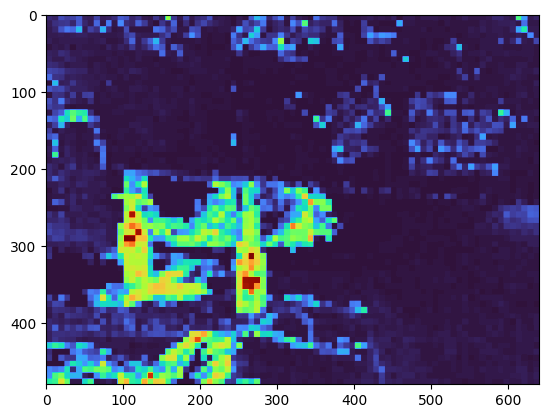

In [19]:
dino1 = tt2dino(tt_frame1)
dino2 = tt2dino(tt_frame2)
print(dino1.shape)

cos_sim = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
gaussian_blur = torchvision.transforms.GaussianBlur(kernel_size=5, sigma=(5.0))

np_cos_sim = cos_sim(dino1, dino2).cpu().numpy()

# np_cos_sim = gaussian_blur(cos_sim(dino1, dino2).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).cpu().numpy()
print(np_cos_sim.shape)

np_dist = (dino1.to(torch.float32) - dino2.to(torch.float32)).mean(dim=2).cpu().numpy()
#normalize to 0-1
np_dist = (np_dist - np_dist.min()) / (np_dist.max() - np_dist.min())

plt.imshow(np_cos_sim, cmap='turbo_r')
